In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from __future__ import division

import brightside as bs
import numpy as np
import ntcir
import ntcir.IO as IO
import os
import re
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import collections
import pandas as pd

In [3]:
users = IO.load_annotations(ntcir.filepaths)
categories = IO.load_categories(ntcir.filepaths)
sorted_users = ntcir.utils.sort(users)
sequences = ntcir.get_sequences(sorted_users, 5)

## Plotting the categories distributions

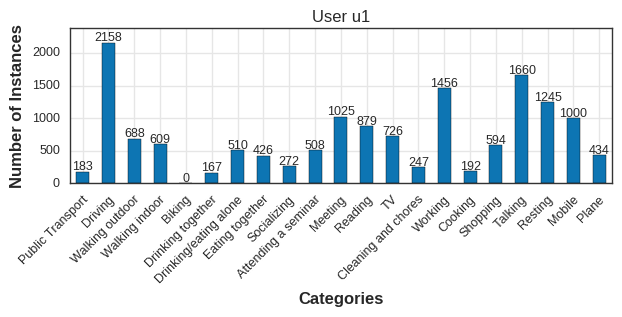

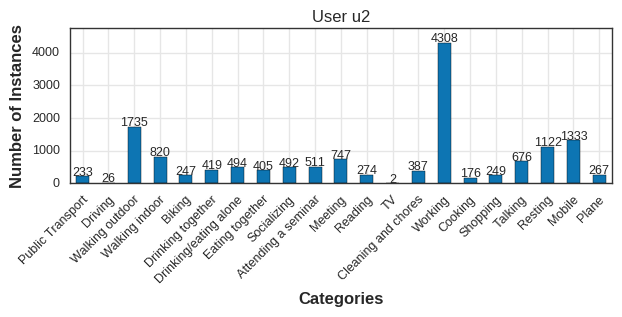

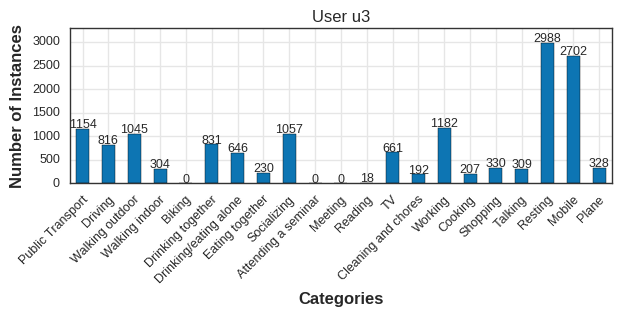

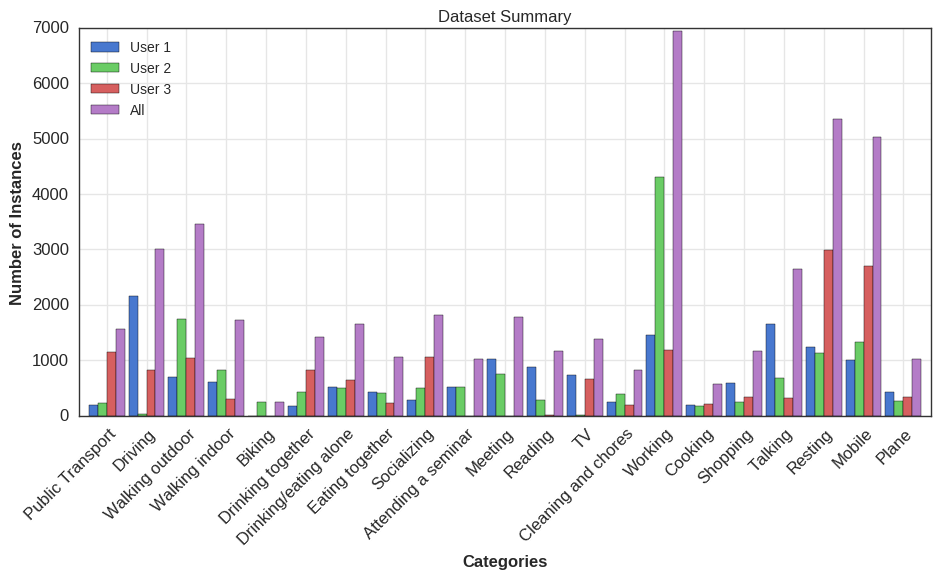

In [4]:
histograms = np.zeros((len(categories)),dtype=np.int)
all_histograms = np.zeros((len(categories),4),dtype=np.int)
for i, user in enumerate(sorted_users):
    user_labels = list()
    for day in user.days:
        for img in day.images:
             user_labels.append(img.label)
    histogram = np.histogram(user_labels, bins=len(categories))[0]
    histograms += histogram
    
    all_histograms[:,i] = histogram
    
    user_histogram = pd.DataFrame(data=histogram, index=categories)
    fig, ax = bs.plot_datasets_summary(user_histogram,figsize=(7,2),annot_rotation=45, axis_fontsize=9,title="User " + user.id_)
    plt.show()
all_histograms[:,i+1] = histograms

histogram = pd.DataFrame(data=all_histograms,index=categories,columns=['User 1','User 2','User 3','All'])


sns.color_palette()
from matplotlib.colors import ListedColormap
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = ListedColormap(sns.color_palette("muted", 4).as_hex())

fig, ax = bs.plot_datasets_summary(histogram,figsize=(11,5),legend=True,width=0.9,annotate_cols=False,annot_rotation=45,colormap=my_cmap,title='Dataset Summary')


## Plotting blocks of sequences separated by 5 min top

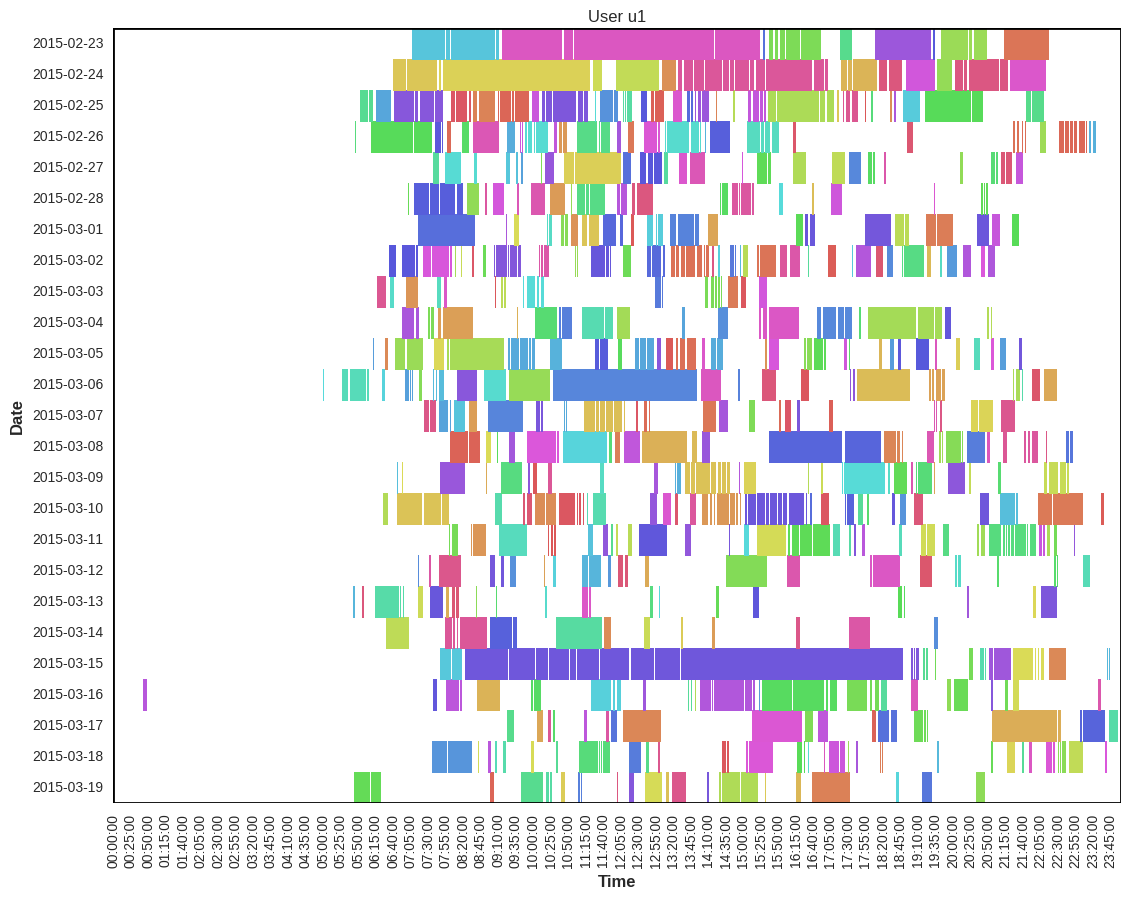

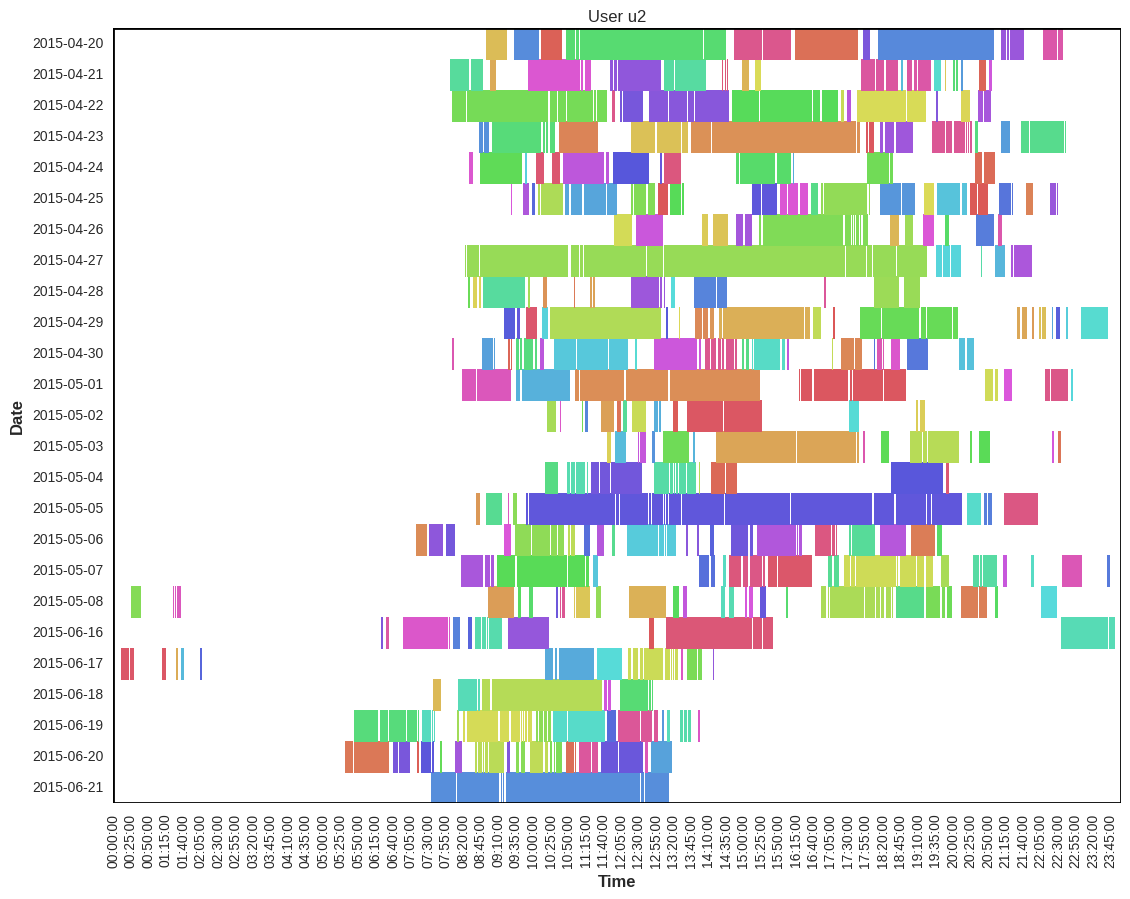

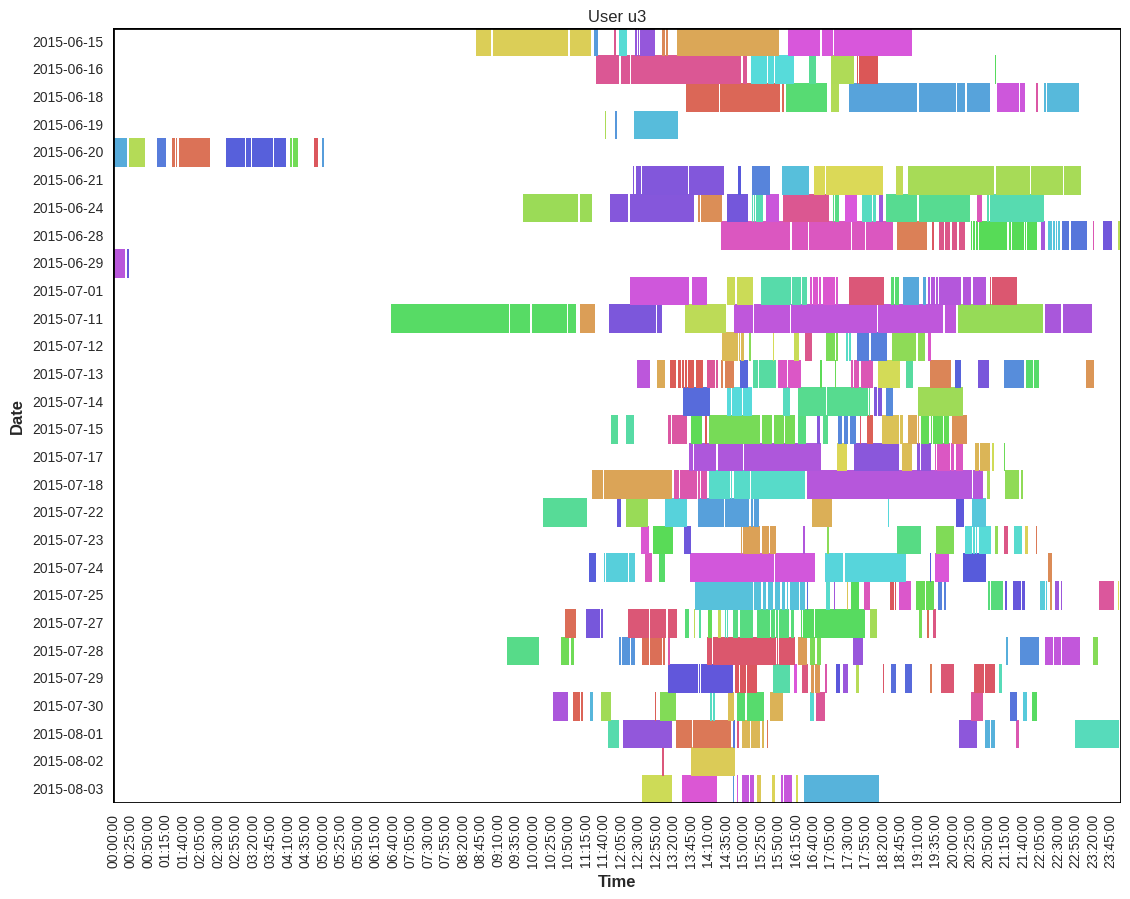

In [5]:
times = list()
for time in itertools.product(xrange(24),xrange(60),xrange(0,60,30)):
    times.append(':'.join([str(t).zfill(2) for t in time]))

np.random.seed(47)
for user in sorted_users:
    days = -np.ones((len(user.days), 2880), np.int)
    dates_labels = list()
    
    label_color_ind = 0
    for i, day in enumerate(user.days):
        dates_labels.append(day.date)
        
        for start, end in sequences[user.id_][day.date]:
            for ind in range(start,end):
                index = ntcir.utils.time2ind(day.images[ind].time)
                days[i,index] = label_color_ind
            label_color_ind += 1
    
    colors = sns.color_palette("hls", label_color_ind)
    np.random.shuffle(colors)
    labels_colors = {i: (str(label), colors[i]) for i, label in enumerate(range(label_color_ind))}

    dataframe = pd.DataFrame(data=days, index=dates_labels,columns=times)        
    fig, ax = bs.show_sequences(dataframe,labels_colors,
                                title='User ' + user.id_,
                                figsize=(13,10),
                                xticklabels=50,
                                mask_value=-1,
                                leg_square_size=7,
                                show_box=True,
                                plot_xlabel='Time',
                                plot_ylabel='Date',
                                legends=False)
    plt.show()

## Plotting the image categories by days

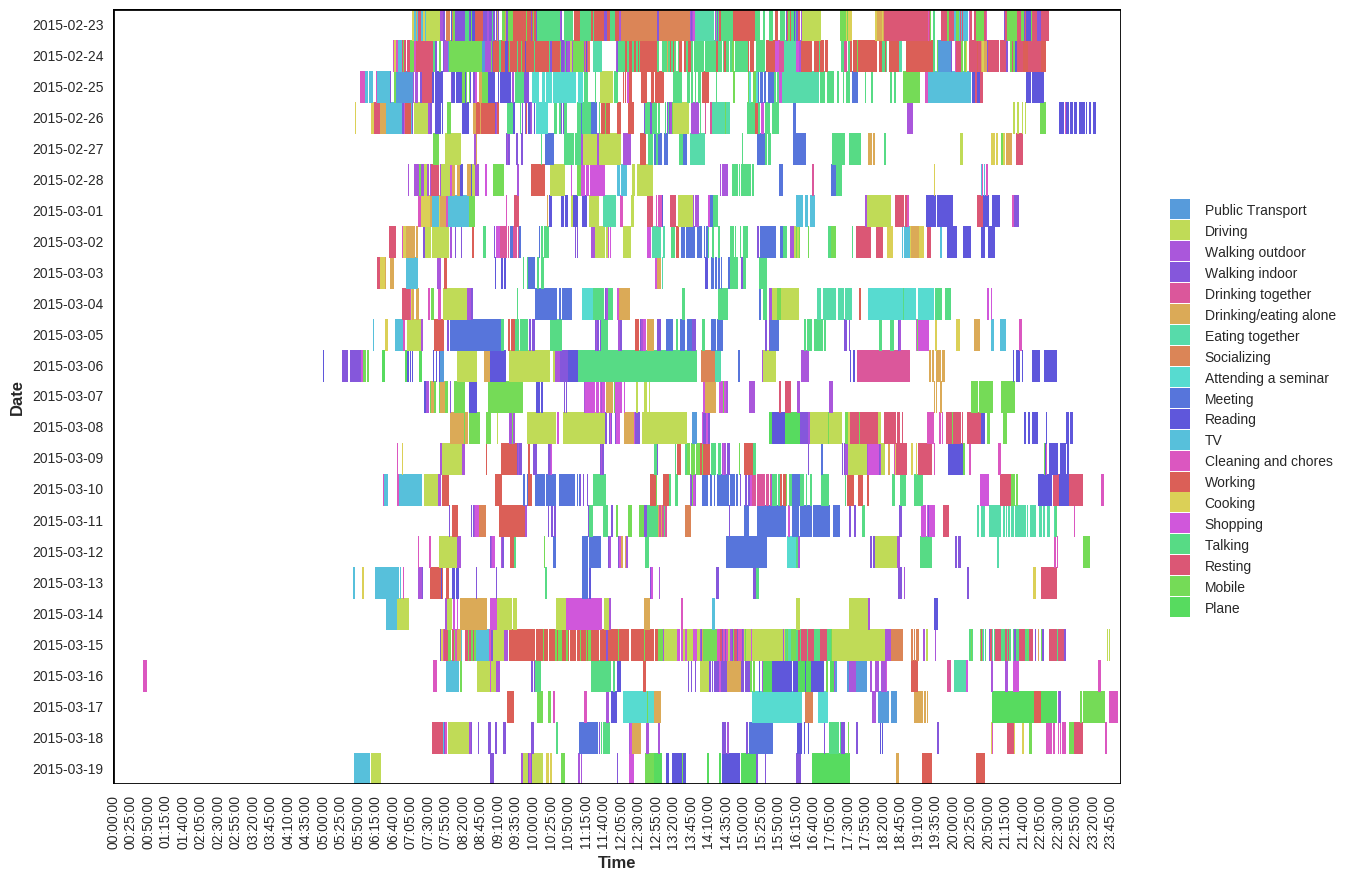

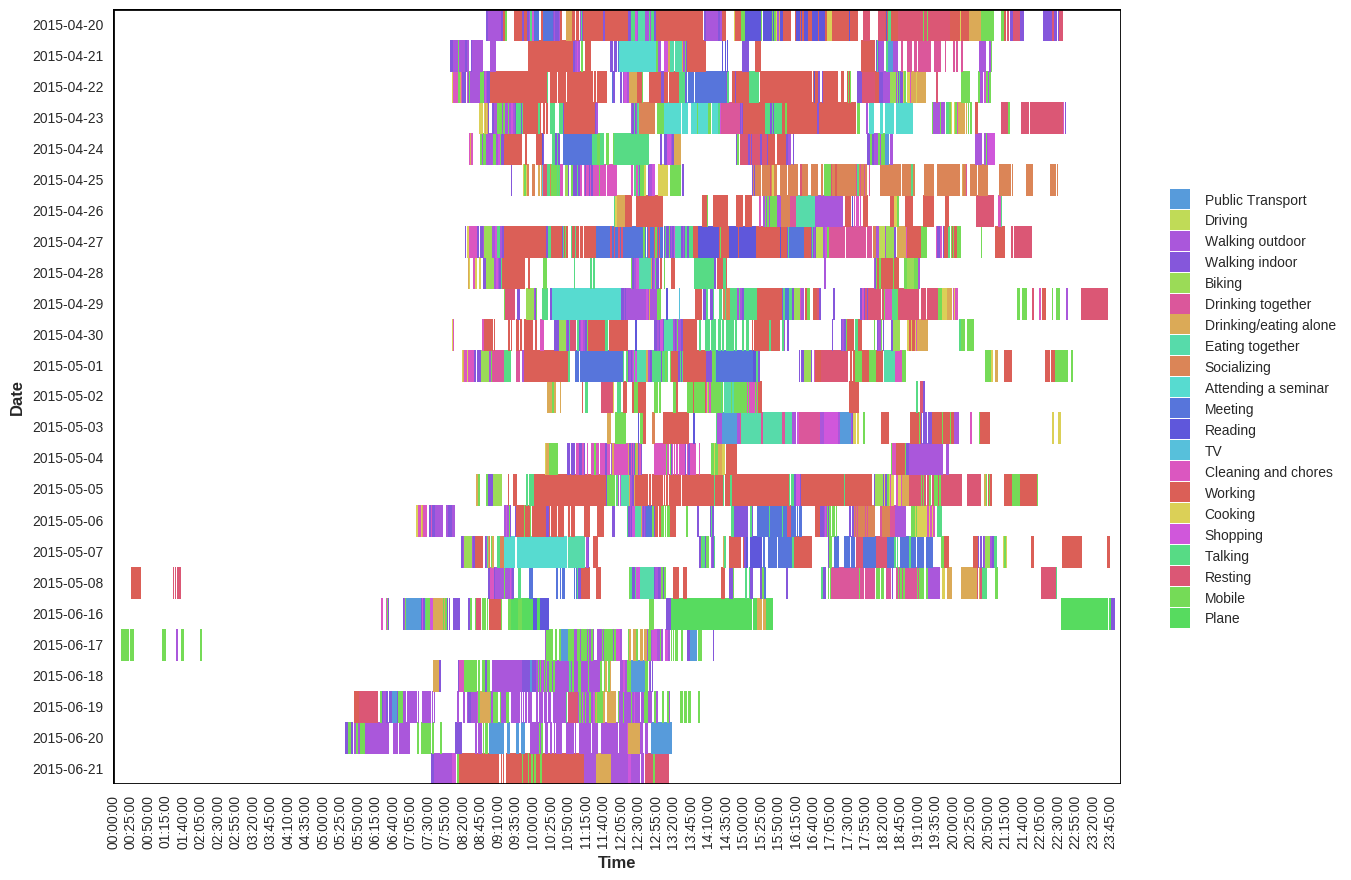

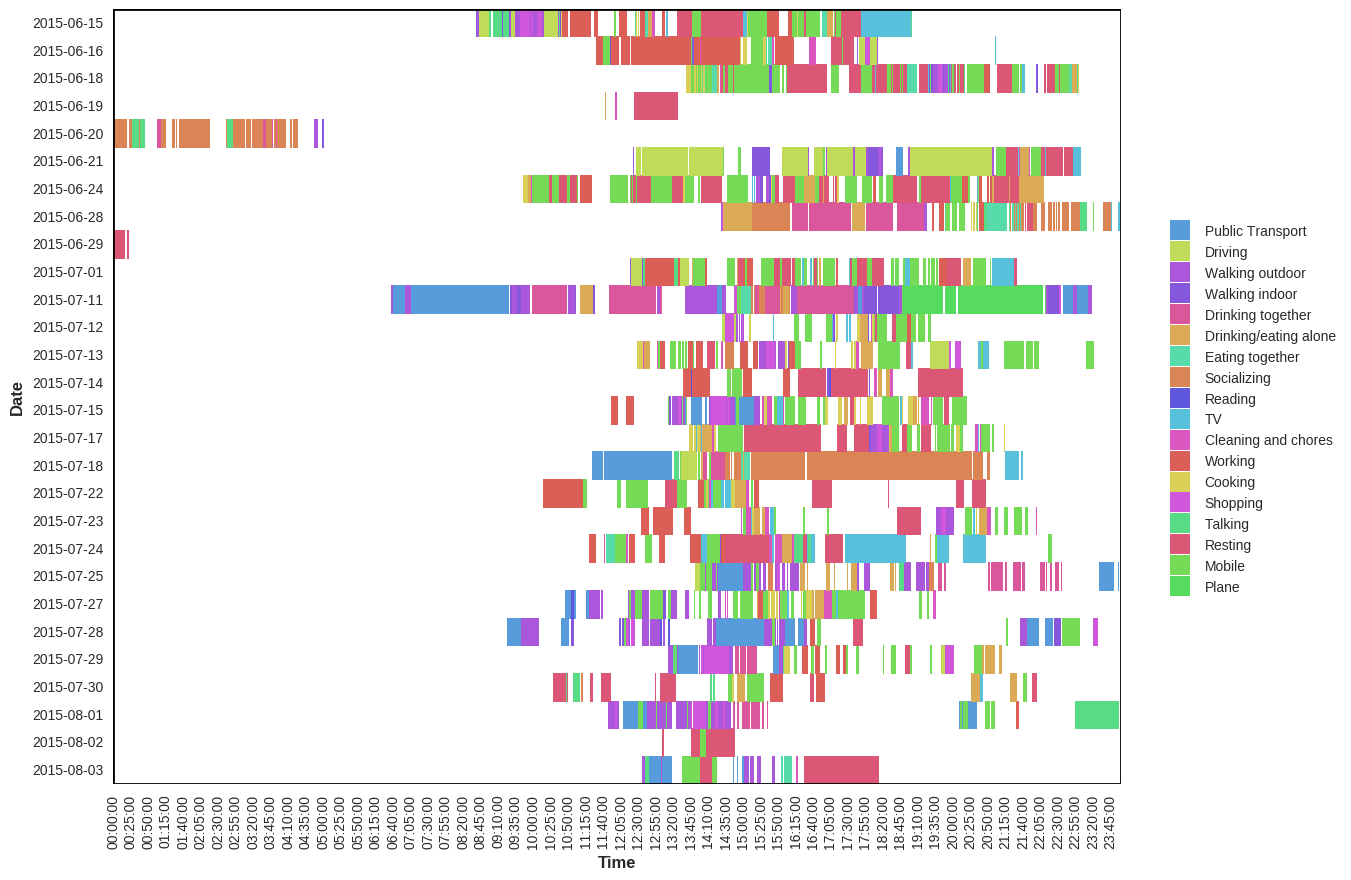

In [6]:
colors = sns.color_palette("hls", len(categories))
np.random.seed(47)
np.random.shuffle(colors)
labels_colors = {i: (label, colors[i]) for i, label in enumerate(categories)}

times = list()
for time in itertools.product(xrange(24),xrange(60),xrange(0,60,30)):
    times.append(':'.join([str(t).zfill(2) for t in time]))
    
for user in sorted_users:    
    days = -np.ones((len(user.days), 2880), np.int)
    dates_labels = list()
    for i, day in enumerate(user.days):
        dates_labels.append(day.date)
        for img in day.images:
            index = ntcir.utils.time2ind(img.time)
            days[i,index] = img.label
            
    dataframe = pd.DataFrame(data=days, index=dates_labels,columns=times)        
    fig, ax = bs.show_sequences(dataframe,labels_colors,figsize=(13,10),xticklabels=50,mask_value=-1,leg_square_size=7,show_box=True,plot_xlabel='Time',plot_ylabel='Date')
    plt.show()

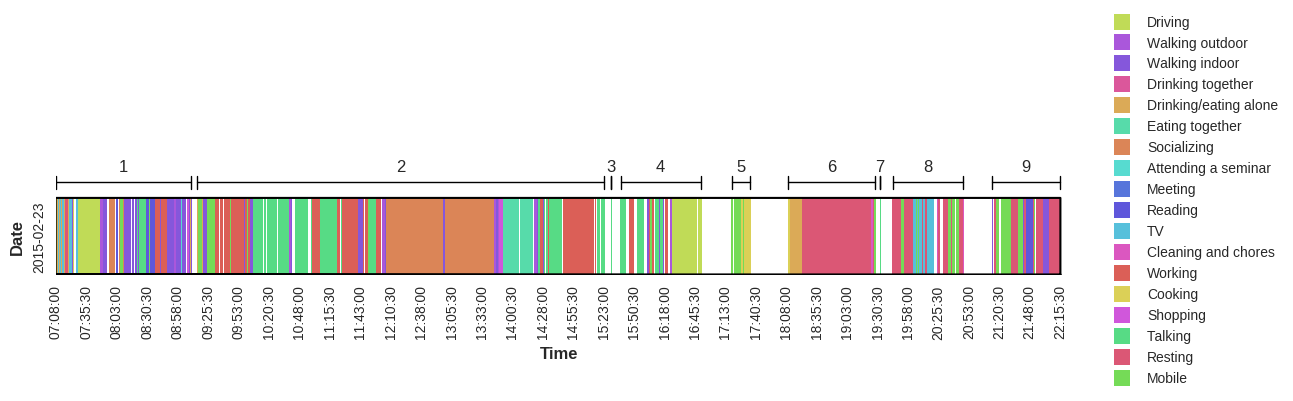

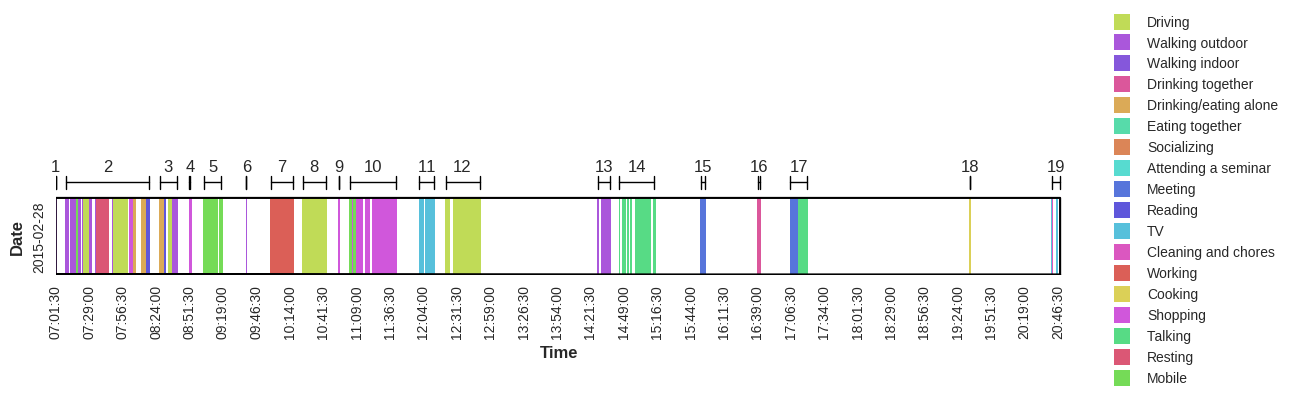

In [52]:
from ntcir import Sequence
reload(bs)

plots = [('u1','2015-02-23'),('u1','2015-02-28')]

activities_union = set()
for user_id, date in plots:    
    for img in users[user_id][date].images:        
        activities_union.add(img.label)
activities_union = list(activities_union)
                        
for user_id, date in plots:
    
    day = users[user_id][date]
    activities = list()
    heatmap = -np.ones((1, 2880), np.int)

    start = -1
    current_label = -1
    last_index = -1
    for j, img in enumerate(day.images):
        index = ntcir.utils.time2ind(img.time)            
        heatmap[0,index] = img.label
        if current_label != img.label or index-last_index > 5:
            if start > -1:                    
                sequence = Sequence(start, last_index)
                name = categories[current_label]
            start = index
            current_label = img.label            
        last_index = index

    start_ind = ntcir.utils.time2ind(day.images[0].time)
    end_ind = ntcir.utils.time2ind(day.images[-1].time)

    dataframe = pd.DataFrame(data=heatmap[:,start_ind:end_ind], index=[date],columns=times[start_ind:end_ind])
    fig, ax = bs.show_sequences(dataframe,labels_colors,
                                figsize=(13,2),
                                xticklabels=55,
                                mask_value=-1,
                                leg_square_size=6,
                                show_box=False,
                                plot_xlabel='Time',
                                plot_ylabel='Date',
                               sequence_ind=activities_union)
    props = {'ha': 'center', 'va': 'bottom'}

    plt.ylim(0,2)
    x_limit = ntcir.utils.time2ind(day.images[-1].time)-start_ind
    plt.xlim(0,x_limit+5)

    # Drawing box around heatmap
    box_x = [0,0,0,x_limit,x_limit,x_limit,0,x_limit]
    box_y = [0,1,1,1,1,0,0.0125,0.0125]
    plt.plot(box_x, box_y, 'k', linewidth=1.5)

    x,y= ax.yaxis.label.get_position()
    ax.yaxis.label.set_position(xy=(x,y/2))

    line_y_coord = 1.2
    for j, (start, end) in enumerate(sequences[user_id][date]):
        s_ind = ntcir.utils.time2ind(day.images[start].time)-start_ind
        e_ind = ntcir.utils.time2ind(day.images[end-1].time)-start_ind
        plt.plot((s_ind, e_ind), (line_y_coord, line_y_coord), 'k')

        plt.plot((s_ind, s_ind), (line_y_coord+0.085, line_y_coord-0.085), 'k-')
        plt.plot((e_ind, e_ind), (line_y_coord+0.085, line_y_coord-0.085), 'k-')
        plt.text((s_ind+e_ind)/2, line_y_coord+0.1, str(j+1), props)
    fig.savefig('{}_{}.png'.format(user_id,date), bbox_inches = 'tight', format='png', dpi=150)
    plt.show()

    

<brightside.Attribute instance at 0x7f87453b1830>

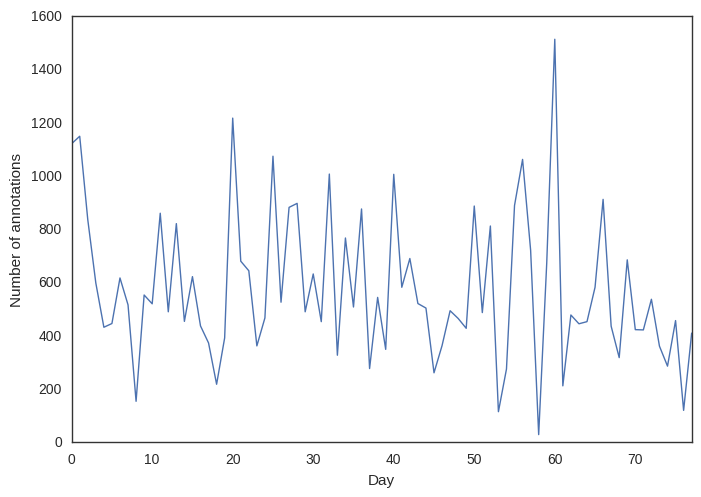

In [36]:
num_annotations_by_day = list()
num_days = 0
for user in sorted_users:    
    for i, day in enumerate(user.days):       
        num_annotations_by_day.append(day.num_images)
        num_days += 1
bs.print_attribute('Total number of days', num_days)

num_annotations_by_day= pd.Series(num_annotations_by_day)
num_annotations_by_day.plot()
plt.xlabel('Day')
plt.ylabel('Number of annotations')
plt.show()

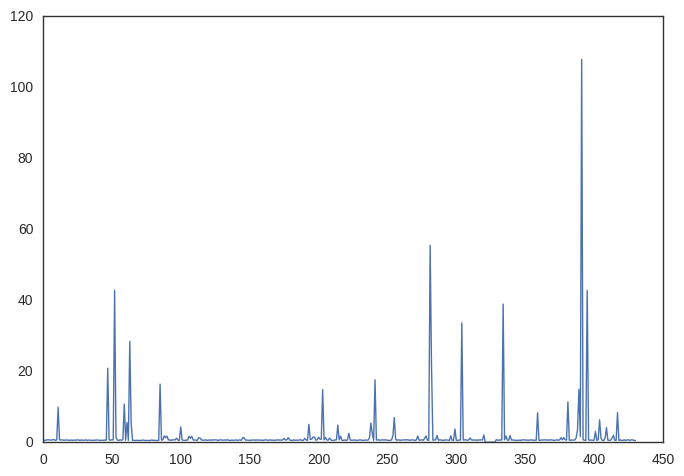

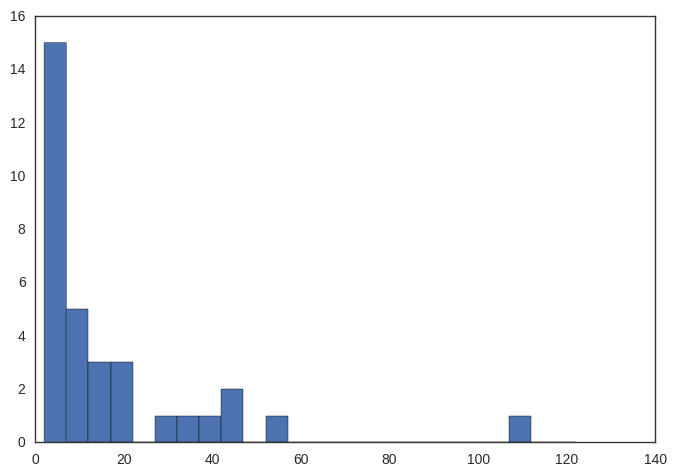

074500 075451
u1 2015-02-27 432 213922


In [17]:
time_diff = list()
for user in sorted_users:    
    for i, day in enumerate(user.days):
        if day.date != '2015-02-27':
            continue
        
        times = np.asarray([ntcir.utils.time2sec(img.time) for img in day.images])
        time_diff = np.diff(times)/60
        
        plt.plot(time_diff)
        plt.show()
        plt.hist(time_diff,[i for i in range(2,125,5)])
        plt.show()
        
        for i in np.where(time_diff>5)[0]:
            print day.images[i].time, day.images[i+1].time
            break
            
        print user.id_, day.date, day.num_images, img.time
        break
    break

In [ ]:
def show_sequences(groundtruth, predictions, labels):
    
    # Creating colormap
    colors = sns.color_palette("hls", len(labels))
#     np.random.shuffle(colors)
    labels_colors = {i: (label, colors[i]) for i, label in enumerate(sorted(labels))}

    true_ind = len(labels)
    false_ind = len(labels)+1
    
    labels_colors[true_ind] = ('True Prediction', (251/255, 48/255, 72/255))
    labels_colors[false_ind] = ('False Prediction', (0, 48/255, 203/255))
    
    sequences = -np.ones((2, len(groundtruth)), np.int)
    for i, (g, p) in enumerate(zip(groundtruth, predictions)):
        sequences[0,i] = g
        sequences[1,i] = true_ind if p == g else false_ind

    fig, ax = bs.show_sequences(sequences,labels_colors, figsize=(13,1), 
                                mask_value=-1, yticklabels=['Groundtruth', 'Prediction'],
                                xticklabels=50, leg_square_size=6, show_box=True, plot_xlabel='Frame')

    plt.show()        